# Training time series data using Deep learning methods

In [3]:
import pandas as pd
import ast
from sklearn.preprocessing import StandardScaler
import numpy as np
from joblib import dump, load
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from sklearn.neural_network import MLPRegressor as MLP
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

/DATAHDD/chailex/anaconda3/envs/eeg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
original_data = pd.read_csv("trial_data.csv")
data = list()
for i in range(len(original_data)):
    temp = list()
    temp.append(original_data.iloc[i,0])
    temp.append(original_data.iloc[i,1])
    list_data = ast.literal_eval(original_data.iloc[i,2])
    temp.append(list_data)
    temp.append(ast.literal_eval(original_data.iloc[i,3]))
    data.append(temp)

In [5]:
df = pd.DataFrame(data)
print(df.head(5))
X = df.iloc[:,2]
print(X.head())
y = df.iloc[:,3]
print(y.head())

   0  1                                                  2       3
0  0  0  [296.75113, 297.27917, 297.03198, 294.42212, 2...  [1, 2]
1  0  0  [296.2985, 295.68347, 295.629, 293.5011, 296.0...  [1, 2]
2  0  0  [295.41623, 296.32166, 296.15216, 294.07843, 2...  [1, 2]
3  0  0  [296.1823, 296.2854, 296.07892, 293.95288, 296...  [1, 2]
4  0  0  [296.6373, 296.11606, 295.98215, 293.76398, 29...  [1, 2]
0    [296.75113, 297.27917, 297.03198, 294.42212, 2...
1    [296.2985, 295.68347, 295.629, 293.5011, 296.0...
2    [295.41623, 296.32166, 296.15216, 294.07843, 2...
3    [296.1823, 296.2854, 296.07892, 293.95288, 296...
4    [296.6373, 296.11606, 295.98215, 293.76398, 29...
Name: 2, dtype: object
0    [1, 2]
1    [1, 2]
2    [1, 2]
3    [1, 2]
4    [1, 2]
Name: 3, dtype: object


In [6]:
time_series_data = X
targets = y

data = pd.DataFrame({'time_series_data': time_series_data, 'target': targets})

In [7]:
X = np.array(data['time_series_data'].tolist())  # Convert the list of lists to a numpy array
y = np.array(data['target'].tolist())

xx = []
yy = []
for i in X:
    temp = []
    for j in range(len(i)):
        temp.append(i[j])
    xx.append(temp)
print(xx[0])

for i in y:
    temp = []
    for j in range(len(i)):
        temp.append(i[j])
    yy.append(temp)
print(yy[0])

X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.3, random_state=42)


[296.75113, 297.27917, 297.03198, 294.42212, 297.5575, 297.9108, 298.78183, 269.8788, 299.4365, 299.80228, 301.5502, 296.61334, 296.3942, 296.2229, 296.10562, 295.96603, 295.76367, 295.51703, 295.10175, 297.16193, 292.90118, 255.68988, 281.30023, 277.15277, 273.1197, 267.8962, 284.83972, 275.8309, 280.47574, 271.51917, 268.62003, 264.09778, 278.44202, 268.34518, 251.91461, 259.44412, 276.6413, 292.0069, 292.19327, 287.16098, 283.96548, 288.48392, 285.56323, 277.2748, 293.57205, 293.19568, 263.18958, 285.62018, 283.77188, 283.66824, 264.8036, 293.8716, 273.19382, 267.3955, 259.90475, 291.10858, 284.45483, 274.52823, 253.43056, 286.8492, 290.08398, 280.19543, 281.19305, 265.41385, 283.5795, 280.97205, 280.51447, 277.1422, 262.18, 278.61526, 260.9042, 257.94183, 292.01938, 287.81735, 284.7387, 287.7805, 280.69727, 282.3179, 281.73276, 288.94962, 286.20865, 289.01465, 292.4256, 289.6274, 290.67892, 291.1715, 291.7375, 292.32, 286.13434, 285.2467, 284.2292, 283.3733, 279.34567, 250.67787, 2

In [31]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CustomDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define your neural network model
class TimeSeriesRegressor(nn.Module):
    def __init__(self):
        super(TimeSeriesRegressor, self).__init__()
        self.fc1 = nn.Linear(1416, 1000)
        self.fc2 = nn.Linear(1000, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 2)  # Output two values for regression

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)  # Linear output layer for regression
        return x

# Instantiate your model
model = TimeSeriesRegressor()

# Check if GPU is available and move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define your loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.HuberLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create a SummaryWriter for TensorBoard
writer = SummaryWriter()
best_metric = float('inf')
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)

    if val_loss < best_metric:
        best_metric = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

writer.close()


Epoch 1/10, Train Loss: 1.9575, Val Loss: 1.7795
Epoch 2/10, Train Loss: 1.8029, Val Loss: 1.7767
Epoch 3/10, Train Loss: 1.7901, Val Loss: 1.7673
Epoch 4/10, Train Loss: 1.7850, Val Loss: 1.7717
Epoch 5/10, Train Loss: 1.7798, Val Loss: 1.8101
Epoch 6/10, Train Loss: 1.7790, Val Loss: 1.7653
Epoch 7/10, Train Loss: 1.7795, Val Loss: 1.7674
Epoch 8/10, Train Loss: 1.7765, Val Loss: 1.7766
Epoch 9/10, Train Loss: 1.7754, Val Loss: 1.7662
Epoch 10/10, Train Loss: 1.7734, Val Loss: 1.7593


In [32]:
class TimeSeriesRegressor(nn.Module):
    def __init__(self):
        super(TimeSeriesRegressor, self).__init__()
        self.fc1 = nn.Linear(1416, 1000)
        self.fc2 = nn.Linear(1000, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 2)  # Output two values for regression

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)  # Linear output layer for regression
        return x

# Instantiate your model
F_model = TimeSeriesRegressor()

F_model.load_state_dict(torch.load('best_model.pth'))
F_model.eval()

with torch.no_grad():  # Disable gradient calculation for inference
    F_model.eval()  # Set the model in evaluation mode
    predictions = F_model(X_test_tensor)

prediction_data = []
for i in predictions:
    temp = []
    temp.append(np.array(i[0]))
    temp.append(np.array(i[1]))
    prediction_data.append(temp)

target_data = []
for j in y_test_tensor:
    temp = []
    temp.append(np.array(j[0]))
    temp.append(np.array(j[1]))
    target_data.append(temp)

print(target_data)
print(prediction_data)

[[array(5., dtype=float32), array(5., dtype=float32)], [array(5., dtype=float32), array(2., dtype=float32)], [array(9., dtype=float32), array(2., dtype=float32)], [array(5., dtype=float32), array(8., dtype=float32)], [array(2., dtype=float32), array(5., dtype=float32)], [array(5., dtype=float32), array(2., dtype=float32)], [array(5., dtype=float32), array(5., dtype=float32)], [array(5., dtype=float32), array(2., dtype=float32)], [array(5., dtype=float32), array(5., dtype=float32)], [array(2., dtype=float32), array(9., dtype=float32)], [array(3., dtype=float32), array(6., dtype=float32)], [array(8., dtype=float32), array(5., dtype=float32)], [array(8., dtype=float32), array(5., dtype=float32)], [array(1., dtype=float32), array(8., dtype=float32)], [array(5., dtype=float32), array(5., dtype=float32)], [array(3., dtype=float32), array(4., dtype=float32)], [array(3., dtype=float32), array(6., dtype=float32)], [array(1., dtype=float32), array(8., dtype=float32)], [array(5., dtype=float32), 

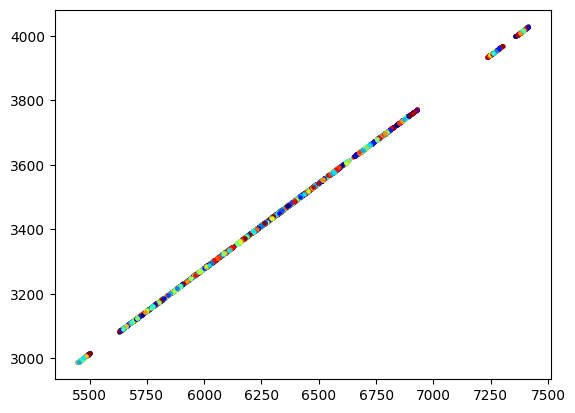

In [33]:
target_colors = plt.cm.jet(np.linspace(0, 1, 21))

target = [[1,2],[1,8],[2,1],[2,5],[2,9],[3,4],[3,6],[4,3],[4,7],[5,2],[5,5],[5,8],[6,3],[6,7],[7,4],[7,6],[8,1],[8,5],[8,9],[9,2],[9,8]]
color_list = {str([1,2]): target_colors[0],str([1,8]): target_colors[19],str([2,1]): target_colors[2],str([2,5]):target_colors[17],str([2,9]):target_colors[4],str([3,4]):target_colors[15],str([3,6]):target_colors[6],str([4,3]):target_colors[13],str([4,7]):target_colors[8],str([5,2]):target_colors[11],str([5,5]):target_colors[10],str([5,8]):target_colors[9],str([6,3]):target_colors[12],str([6,7]):target_colors[7],str([7,4]):target_colors[14],str([7,6]):target_colors[5],str([8,1]):target_colors[16],str([8,5]):target_colors[3],str([8,9]):target_colors[18],str([9,2]):target_colors[1],str([9,8]):target_colors[20]}

image = cv2.imread('./points.jpg')
image_height, image_width, _ = image.shape
# scaled_targets = [(int(x * image_width), int(y * image_height)) for x, y in target]

scaled_predicted_points = [(int(x * image_width), int(y * image_height)) for x, y in prediction_data]
scaled_target_points_color = [color_list[str([int(i[0]),int(i[1])])] for i in target_data]

counter = 0
for point in scaled_predicted_points:
    plt.scatter(point[0], point[1], color=scaled_target_points_color[counter], s=5, marker='o')  # Adjust marker size and color as needed
    counter += 1

# for point in target_data:
#     plt.scatter(int(point[0] * image_width), int(point[1] * image_height), color=color_list[str(point)], s=25, marker='o')  # Adjust marker size and color as needed


# Show the plot
plt.show()
